In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import utils

SVC

In [2]:
# Load dataset
tracks = utils.load('fma_metadata/tracks.csv')
features = utils.load('fma_metadata/features.csv')
echonest = utils.load('fma_metadata/echonest.csv')

In [ ]:
# subset the data to medium set to match baseline
subset = tracks.index[tracks['set', 'subset'] <= 'medium']

assert subset.isin(tracks.index).all()
assert subset.isin(features.index).all()

features_all = features.join(echonest, how='inner').sort_index(axis=1)
print('Not enough Echonest features: {}'.format(features_all.shape))

tracks = tracks.loc[subset]
features_all = features.loc[subset]

tracks.shape, features_all.shape

In [4]:
features.columns = [' '.join(col) for col in features.columns]
features = features.reset_index()
features.head()

,track_id,chroma_cens kurtosis 01,chroma_cens kurtosis 02,chroma_cens kurtosis 03,chroma_cens kurtosis 04,chroma_cens kurtosis 05,chroma_cens kurtosis 06,chroma_cens kurtosis 07,chroma_cens kurtosis 08,chroma_cens kurtosis 09,...,tonnetz std 04,tonnetz std 05,tonnetz std 06,zcr kurtosis 01,zcr max 01,zcr mean 01,zcr median 01,zcr min 01,zcr skew 01,zcr std 01
0,2,7.180653,5.230309,0.249321,1.347620,1.482478,0.531371,1.481593,2.691455,0.866868,...,0.054125,0.012226,0.012111,5.758890,0.459473,0.085629,0.071289,0.000000,2.089872,0.061448
1,3,1.888963,0.760539,0.345297,2.295201,1.654031,0.067592,1.366848,1.054094,0.108103,...,0.063831,0.014212,0.017740,2.824694,0.466309,0.084578,0.063965,0.000000,1.716724,0.069330
2,5,0.527563,-0.077654,-0.279610,0.685883,1.937570,0.880839,-0.923192,-0.927232,0.666617,...,0.040730,0.012691,0.014759,6.808415,0.375000,0.053114,0.041504,0.000000,2.193303,0.044861
3,10,3.702245,-0.291193,2.196742,-0.234449,1.367364,0.998411,1.770694,1.604566,0.521217,...,0.074358,0.017952,0.013921,21.434212,0.452148,0.077515,0.071777,0.000000,3.542325,0.040800
4,20,-0.193837,-0.198527,0.201546,0.258556,0.775204,0.084794,-0.289294,-0.816410,0.043851,...,0.095003,0.022492,0.021355,16.669037,0.469727,0.047225,0.040039,0.000977,3.189831,0.030993


In [5]:
label = tracks["track", "genre_top"].dropna().reset_index()
label.columns = [''.join(col) for col in label.columns]
label = label.rename(columns={"trackgenre_top" : "genre"})

In [6]:
data = features.merge(label, how="inner", on="track_id")
data = data.drop(columns="track_id")
data

,chroma_cens kurtosis 01,chroma_cens kurtosis 02,chroma_cens kurtosis 03,chroma_cens kurtosis 04,chroma_cens kurtosis 05,chroma_cens kurtosis 06,chroma_cens kurtosis 07,chroma_cens kurtosis 08,chroma_cens kurtosis 09,chroma_cens kurtosis 10,...,tonnetz std 05,tonnetz std 06,zcr kurtosis 01,zcr max 01,zcr mean 01,zcr median 01,zcr min 01,zcr skew 01,zcr std 01,genre
0,7.180653,5.230309,0.249321,1.347620,1.482478,0.531371,1.481593,2.691455,0.866868,1.341231,...,0.012226,0.012111,5.758890,0.459473,0.085629,0.071289,0.000000,2.089872,0.061448,Hip-Hop
1,1.888963,0.760539,0.345297,2.295201,1.654031,0.067592,1.366848,1.054094,0.108103,0.619185,...,0.014212,0.017740,2.824694,0.466309,0.084578,0.063965,0.000000,1.716724,0.069330,Hip-Hop
2,0.527563,-0.077654,-0.279610,0.685883,1.937570,0.880839,-0.923192,-0.927232,0.666617,1.038546,...,0.012691,0.014759,6.808415,0.375000,0.053114,0.041504,0.000000,2.193303,0.044861,Hip-Hop
3,3.702245,-0.291193,2.196742,-0.234449,1.367364,0.998411,1.770694,1.604566,0.521217,1.982386,...,0.017952,0.013921,21.434212,0.452148,0.077515,0.071777,0.000000,3.542325,0.040800,Pop
4,0.918445,0.674147,0.577818,1.281117,0.933746,0.078177,1.199204,-0.175223,0.925482,1.438509,...,0.016322,0.015819,4.731087,0.419434,0.064370,0.050781,0.000000,1.806106,0.054623,Hip-Hop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49593,-0.319850,0.653044,1.300360,-0.606061,-1.109302,-1.006683,0.059643,0.472580,-0.856436,-0.524676,...,0.016631,0.014705,6.947788,0.188477,0.037708,0.035156,0.002930,1.764233,0.018679,Rock
49594,-0.490129,0.463834,2.321970,-0.084352,1.662914,2.115189,-0.237794,5.695442,0.830353,1.951819,...,0.022547,0.019816,4.448255,0.172852,0.028773,0.028320,0.003906,0.955388,0.012385,Rock
49595,-0.461559,-0.229601,-0.496632,-0.422033,0.130612,-0.263825,-0.628103,-0.082687,-0.229483,-0.492753,...,0.023548,0.026527,3.270612,0.196289,0.031116,0.027832,0.002441,1.283060,0.019059,Rock
49596,0.552473,-0.110498,-0.532014,0.263131,-0.224011,-0.530972,1.713526,1.418444,1.325197,0.120333,...,0.017540,0.020471,2.356727,0.212891,0.038450,0.037109,0.003418,0.828569,0.017904,Rock


In [7]:
# Prepare features and labels
y = data['genre']
X = data.drop(columns=['genre'])

In [8]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [9]:
# Check class distribution
class_distribution = y_train.value_counts()
print("Class distribution in training data:\n", class_distribution)

Class distribution in training data:
 genre
Rock                   9907
Experimental           7449
Electronic             6567
Hip-Hop                2505
Folk                   1955
Pop                    1624
Instrumental           1432
International           985
Classical               872
Jazz                    405
Old-Time / Historic     384
Spoken                  300
Country                 126
Soul-RnB                116
Blues                    76
Easy Listening           15
Name: count, dtype: int64


In [10]:
# Dynamically adjust sampling strategies based on data
minority_threshold = int(class_distribution.mean() * 0.5)
majority_threshold = int(class_distribution.mean() * 2)

smote_strategy = {genre: max(minority_threshold, count) for genre, count in class_distribution.items() if count < minority_threshold}
undersample_strategy = {genre: min(majority_threshold, count) for genre, count in class_distribution.items() if count > majority_threshold}

print("SMOTE strategy:", smote_strategy)
print("Undersample strategy:", undersample_strategy)

SMOTE strategy: {'International': 1084, 'Classical': 1084, 'Jazz': 1084, 'Old-Time / Historic': 1084, 'Spoken': 1084, 'Country': 1084, 'Soul-RnB': 1084, 'Blues': 1084, 'Easy Listening': 1084}
Undersample strategy: {'Rock': 4339, 'Experimental': 4339, 'Electronic': 4339}


In [11]:
# Balance the classes using SMOTE and undersampling
oversample = SMOTE(sampling_strategy=smote_strategy, random_state=42)
undersample = RandomUnderSampler(sampling_strategy=undersample_strategy, random_state=42)

In [12]:
# Create a pipeline to scale features and apply SMOTE/undersampling
scaler = StandardScaler()

pipeline = Pipeline([
    ('scaler', scaler),  # Scale features
    ('oversample', oversample),
    ('undersample', undersample)
])

X_resampled, y_resampled = pipeline.fit_resample(X_train, y_train)

In [13]:
# Hyperparameter tuning with GridSearchCV
svc_pipeline = Pipeline([
    ('scaler', scaler),
    ('svc', SVC(class_weight='balanced'))
])

param_grid = {
    'svc__C': [0.1, 1, 10, 100],
    'svc__gamma': [0.001, 0.01, 0.1, 1],
    'svc__kernel': ['rbf']
}

grid_search = GridSearchCV(estimator=svc_pipeline, param_grid=param_grid, scoring='f1_macro', cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_resampled, y_resampled)


Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svc', SVC(class_weight='balanced'))]),
             n_jobs=-1,
             param_grid={'svc__C': [0.1, 1, 10, 100],
                         'svc__gamma': [0.001, 0.01, 0.1, 1],
                         'svc__kernel': ['rbf']},
             scoring='f1_macro', verbose=1)

In [14]:
# Best parameters and model
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

best_model = grid_search.best_estimator_

Best Parameters: {'svc__C': 10, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


In [15]:
# Predict and evaluate
predictions = best_model.predict(X_test)

/opt/homebrew/Caskroom/miniconda/base/envs/ml_project/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [16]:
# Classification report
report = classification_report(y_test, predictions)
print("Classification Report:\n", report)

Classification Report:
                      precision    recall  f1-score   support

              Blues       0.00      0.00      0.00        34
          Classical       0.00      0.00      0.00       358
            Country       0.00      0.00      0.00        68
     Easy Listening       0.00      0.00      0.00         9
         Electronic       0.00      0.00      0.00      2805
       Experimental       0.21      1.00      0.35      3159
               Folk       0.00      0.00      0.00       848
            Hip-Hop       0.00      0.00      0.00      1047
       Instrumental       0.00      0.00      0.00       647
      International       0.00      0.00      0.00       404
               Jazz       0.00      0.00      0.00       166
Old-Time / Historic       0.00      0.00      0.00       170
                Pop       0.00      0.00      0.00       708
               Rock       0.00      0.00      0.00      4275
           Soul-RnB       0.00      0.00      0.00        59

/opt/homebrew/Caskroom/miniconda/base/envs/ml_project/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/ml_project/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/ml_project/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

In [17]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, predictions, labels=y.unique())
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[   0    0    0 1047    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0  708    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0 4275    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0 3159    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0  848    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0  166    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0 2805    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0  123    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0  404    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0   59    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0   34    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0   68    0    0    0    0    0

In [18]:
# Visualization Example
def plot_confusion_matrix(matrix, labels):
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

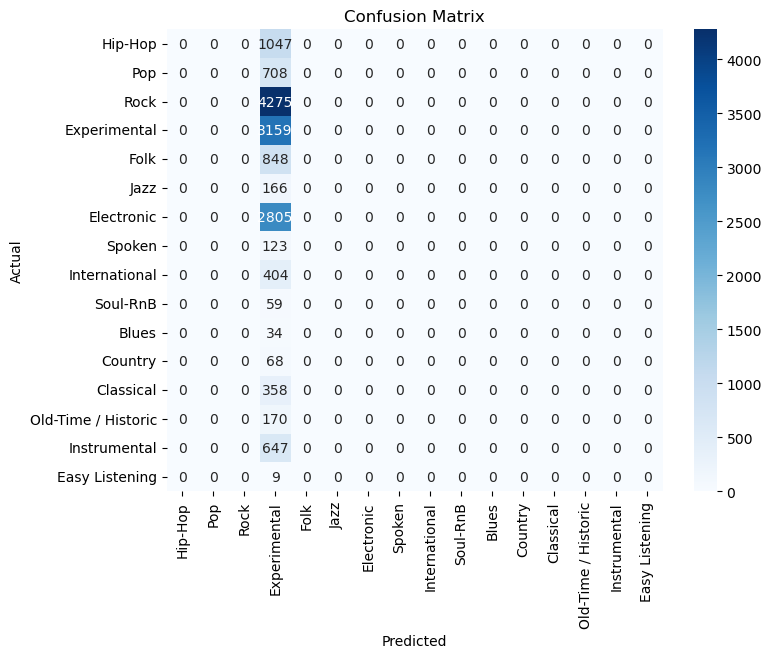

In [19]:
plot_confusion_matrix(conf_matrix, y.unique())

Random Forest

In [ ]:
# Load dataset
tracks = utils.load('fma_metadata/tracks.csv')
features = utils.load('fma_metadata/features.csv')
echonest = utils.load('fma_metadata/echonest.csv')

# subset the data to medium set to match baseline
subset = tracks.index[tracks['set', 'subset'] <= 'medium']

assert subset.isin(tracks.index).all()
assert subset.isin(features.index).all()


tracks = tracks.loc[subset]
features_all = features.loc[subset]

# Merge and preprocess data
features_all.columns = [' '.join(col) for col in features_all.columns]
features = features_all.reset_index()
label = tracks["track", "genre_top"].dropna().reset_index()
label.columns = [''.join(col) for col in label.columns]
label = label.rename(columns={"trackgenre_top" : "genre"})
data = features.merge(label, how="inner", on="track_id")
data = data.drop(columns="track_id")


# Prepare features and labels
y = data['genre']
X = data.drop(columns=['genre'])

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Check class distribution
class_distribution = y_train.value_counts()

# Dynamically adjust sampling strategies based on data
minority_threshold = int(class_distribution.mean() * 0.5)
majority_threshold = int(class_distribution.mean() * 2)

smote_strategy = {genre: max(minority_threshold, count) for genre, count in class_distribution.items() if count < minority_threshold}
undersample_strategy = {genre: min(majority_threshold, count) for genre, count in class_distribution.items() if count > majority_threshold}

# Balance the classes using SMOTE and undersampling
oversample = SMOTE(sampling_strategy=smote_strategy, random_state=42)
undersample = RandomUnderSampler(sampling_strategy=undersample_strategy, random_state=42)

# Create a pipeline
pipeline = Pipeline([
    ('oversample', oversample),
    ('undersample', undersample)
])

X_resampled, y_resampled = pipeline.fit_resample(X_train, y_train)

# Train a Random Forest classifier
clf = RandomForestClassifier(class_weight='balanced', random_state=42)
clf.fit(X_resampled, y_resampled)

# Predict and evaluate
predictions = clf.predict(X_test)

Class distribution in training data:
 genre
Rock                   4899
Electronic             4387
Experimental           1626
Hip-Hop                1565
Folk                   1090
Instrumental            952
Pop                     839
International           712
Classical               425
Old-Time / Historic     354
Jazz                    271
Country                 124
Soul-RnB                105
Spoken                   85
Blues                    53
Easy Listening           13
Name: count, dtype: int64
SMOTE strategy: {'Classical': 546, 'Old-Time / Historic': 546, 'Jazz': 546, 'Country': 546, 'Soul-RnB': 546, 'Spoken': 546, 'Blues': 546, 'Easy Listening': 546}
Undersample strategy: {'Rock': 2187, 'Electronic': 2187}
Classification Report:
                      precision    recall  f1-score   support

              Blues       1.00      0.19      0.32        21
          Classical       0.74      0.77      0.76       194
            Country       0.86      0.35      0.50      

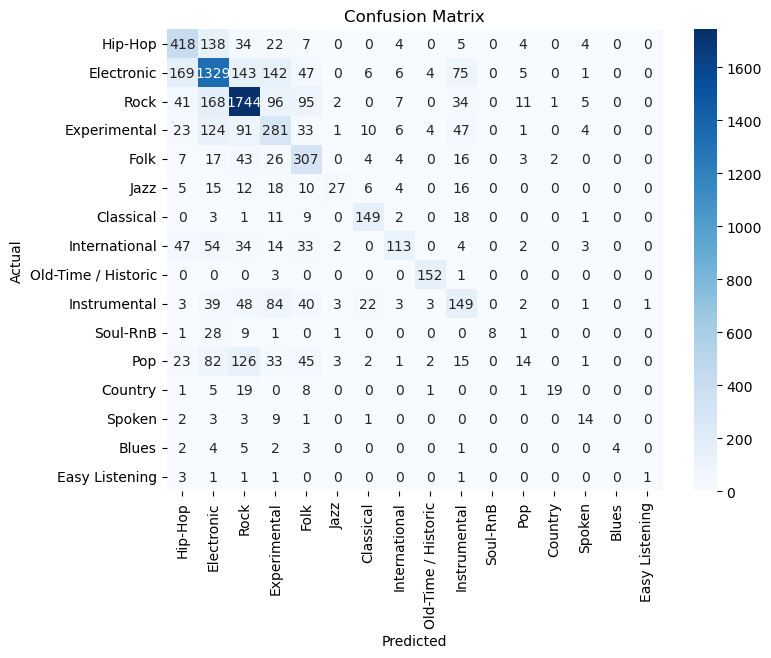

In [ ]:
print("Class distribution in training data:\n", class_distribution)

print("SMOTE strategy:", smote_strategy)
print("Undersample strategy:", undersample_strategy)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, predictions, labels=y_train.unique())
print("Confusion Matrix:\n", conf_matrix)

# Visualization Example
def plot_confusion_matrix(matrix, labels):
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(conf_matrix, y_train.unique())


In [21]:
# Classification report
report = classification_report(y_test, predictions)
print("Classification Report:\n", report)

Classification Report:
                      precision    recall  f1-score   support

              Blues       1.00      0.19      0.32        21
          Classical       0.74      0.77      0.76       194
            Country       0.86      0.35      0.50        54
     Easy Listening       0.50      0.12      0.20         8
         Electronic       0.66      0.69      0.68      1927
       Experimental       0.38      0.45      0.41       625
               Folk       0.48      0.72      0.58       429
            Hip-Hop       0.56      0.66      0.61       636
       Instrumental       0.39      0.37      0.38       398
      International       0.75      0.37      0.50       306
               Jazz       0.69      0.24      0.36       113
Old-Time / Historic       0.92      0.97      0.94       156
                Pop       0.32      0.04      0.07       347
               Rock       0.75      0.79      0.77      2204
           Soul-RnB       1.00      0.16      0.28        49